In [2]:
from rayleigh_diagnostics import Shell_Avgs, ReferenceState
import matplotlib.pyplot as plt
import numpy
import os
import sys
from scipy.integrate import simps
%matplotlib inline

In [14]:
# Need to correct reference file with correct nr value
def conductive_entropy_profile(rho, temp, radius, S_i=-1, Q=[-1], kappa=-1):    
    """ Returns the conductive entropy profile
         Arrays are assumed to be in standard,
         Rayleigh-reversed order.
         rho  : density from reference file
         temp : temperature from reference file
         S_i  : entropy at inner boundary
         Q    : reference heating as function of radius"""
    from scipy.integrate import simps
    # Create reversed copies of the arrays for Simpson's integration routine
    rrev=radius[::-1]
    trev=temp[::-1]
    drev=rho[::-1]
    nr = len(rrev)
    #case 1, S_i (S at inner boundary) is provided
    if (S_i > 0):
        g = 1.0/(rrev*rrev*drev*trev) #the integrand
        f = numpy.zeros(nr,dtype='d')
        for i in range(nr):
            f[i]= simps(g[0:i+1],rrev[0:i+1])
        A = S_i/(f[0]-f[nr-1])
        scond_rev = A*(f-f[nr-1])

    #case 2, Q is provided
    if ((len(Q) == nr) and (kappa > 0) ):
        # first compute h(r) = int Q(x) x^2 dx
        qrev = Q[::-1]
        qx2 = -qrev*rrev*rrev
        h = numpy.zeros(nr,dtype='d')
        for i in range(nr):
            h[i]=simps(qx2[0:i+1],rrev[0:i+1])
        # h[nr-1] = 0
        g = 1.0/(rrev*rrev*drev*trev*kappa)
        # g = (rrev)/(3*drev*trev*kappa)
        hgi = h*g

        M = numpy.zeros(nr,dtype='d')

        for i in range(nr):
            M[i]=simps(hgi[0:i+1],rrev[0:i+1])

        Mo = M[nr-1]
        B = -Mo
        scond_rev = M+B

    scond = scond_rev[::-1]
    return scond   

Nusselt: 1.457227107962258
Nusselt: 1.6510616821959354
Nusselt: 1.1531793490460625
Nusselt: 4.372019611849109
Nusselt: 2.900539730494807
Nusselt: 1.9978522895878232
Nusselt: 1.0041604710699938
Nusselt: 1.0002029051424859
Nusselt: 1.0002029051419197
Nusselt: 1.0002029051404997
Nusselt: 2.890906691475811
Nusselt: 1.2862534090832567
Nusselt: 1.0343721124353196
Nusselt: 1.0087179160126982
Nusselt: 1.021125604746786
Nusselt: 1.000202905141917

*******************************************
Nusselt: 1.3859854353998313
Nusselt: 2.6792255547454205
Nusselt: 4.039155902854453
Nusselt: 1.0000072131189872
Nusselt: 1.1520290616636473
Nusselt: 6.273861150756821
Nusselt: 1.2517695844932701
Nusselt: 1.0028201903125722
Nusselt: 1.4453913936005955
Nusselt: 1.619370913855703
Nusselt: 1.077775775987604
Nusselt: 1.771258947267596

*******************************************
Nusselt: 1.5274293839469488
Nusselt: 1.0000304709243208
Nusselt: 1.2954299104497335
Nusselt: 5.398924460827034
Nusselt: 1.48373195994218


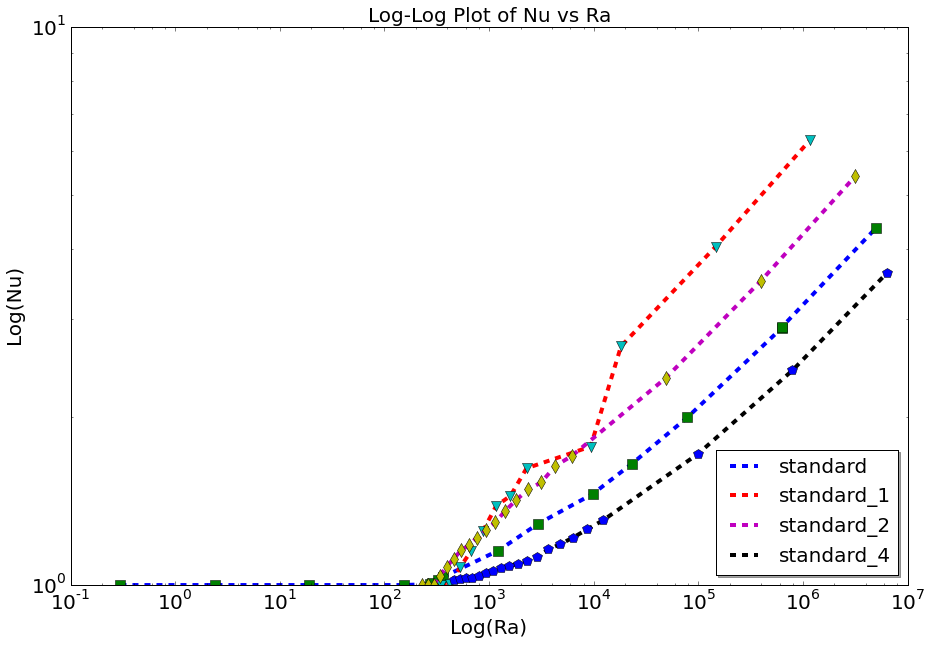

In [16]:
standardl = ['standard','standard_1','standard_2','standard_4']
# standardl = ['standard']
countdir = -1

sfile = './time_test'
# rfile = './reference'

sizetuple=(15,10)
fig, ax = plt.subplots(figsize=sizetuple)

# make a list of the directories inside of each standard case
for k in standardl:
    # print('Working directory: ' + os.getcwd())
    rootdir = '/gpfs/summit/scratch/frra1220/test_nonrotating/' + k
    countdir += 1
    dirlist = []
    # rfile = rootdir + '/reference'
     
    nulist = []
    ralist = []
    
    for root, dirs, files in os.walk(rootdir):
        dirlist += dirs
    
    for i in dirlist:
        try:
            os.chdir(rootdir + '/' + i)
            # print('Working directory: ' + os.getcwd())
            # print()
            kappa = float(i.split('_')[-1] + 'e12')
            sa = Shell_Avgs(sfile,path='')
            if k == 'standard' and sa.nr == 256:
                rfile = rootdir + '/reference_3nrho256'
            elif k == 'standard' and sa.nr == 64:
                rfile = rootdir + '/reference_3nrho64'
            elif k == 'standard_4' and sa.nr == 256:
                rfile = rootdir + '/reference_4nrho256' 
            else:
                rfile = rootdir + '/reference'
            ref = ReferenceState(rfile,path='')
            rho = ref.density
            temp = ref.temperature
            grav = ref.gravity
            radius = sa.radius
            nr = sa.nr
            # print(nr)
            entropy_code=4  #This was entropy in original version of Rayleigh
            entropy = sa.vals[:,sa.lut[entropy_code],0]
        
            lsun=3.846e33

            qfunc = rho*temp # - rho[0]*temp[0]
            qfi = qfunc*radius*radius*4*numpy.pi

            qrev = qfi[::-1]
            rrev = radius[::-1]

            qint = simps(qrev,rrev)/lsun
            qfunc=qfunc/qint
            qrev = qrev/qint
            ######################################################

            ################################################################
            # Compute the conductive entropy profile associated 
            # with the internal heating function  AND the value of kappa
            # taken from main_input  (or the directory name)
            # This calculates the conductive profile for when NO CONVECTION is present
            
            ## Changes for each case so running the loop will actually not work. 
            # kappa=2e12
        
            scond = conductive_entropy_profile(rho,temp,radius,Q=qfunc,kappa=kappa)
            #scond1 = conductive_entropy_profile(rho,temp,radius,Q=qfunc*(entropy[nr-1]/scond[nr-1]),kappa=kappa)
            ratio=(entropy[nr-1]/scond[nr-1])
            qnew = qfunc[:]*ratio
            scond1 = conductive_entropy_profile(rho,temp,radius,Q=qnew,kappa=kappa)
            #scond1 = scond
            # ratio= entropy[nr-1]/scond[nr-1]
            # ratio = 1
            ###################################################################
            # Compute the conductive entropy profile consistent with the entropy
            # contrast realized in the simulation
            s_inner = entropy[nr-1] #note that outer boundary is assumed to be zero
            scond2 = conductive_entropy_profile(rho,temp,radius,S_i=s_inner)

            # Compute the conductive flux associated with each entropy profile
            # Conductive Flux = - rho T kappa dSdr

            # For some versions of numpy, the gradient works this way:
            #dr = numpy.gradient(radius)
            #dscond2 = numpy.gradient(scond2,dr)
            #dscond  = numpy.gradient(scond,dr)

            #For others, though, you pass it radius, rather than dr:
            dscond1 = numpy.gradient(scond1,radius)
            dscond  = numpy.gradient(scond,radius)

            fscond1 = -rho*temp*kappa*dscond1
            fscond  = -rho*temp*kappa*dscond

            # Compute a Nusselt number Nu
            # Nu = {Integral of heating-associated conductive flux} / {Integral of entropy-contrast conductive flux}
            numerator = fscond*4*numpy.pi*radius*radius
            denom = fscond1*4*numpy.pi*radius*radius

            num_int = simps(numerator[::-1],radius[::-1])
            denom_int = simps(denom[::-1],radius[::-1])

            Nu = num_int/denom_int
            # nulist += Nu
            nulist.append(Nu)
        
            print('Nusselt: ' + str(Nu))
        
            # fig, ax = plt.subplots()
            # ax.plot(radius,entropy)  # The entropy profile realized in the model (with convection)
            # ax.plot(radius,scond2)    # The conductive entropy profile that corresponds the same entropy contrast as that realized above
            # ax.plot(radius,scond1)   # The conductive entropy profile that would be realized in the absence of convection
            # ax.plot(radius,dscond)
            # ax.plot(radius,dscond2)
            
            # plt.show()
        
            h = rrev[-1] - rrev[0]
            cp = 3.5e8
            nu = kappa

            # Normalization value (Double check if volume makes sense):
            normaliz = numpy.trapz(rrev**2, rrev)
            # print('Volume: '+ str(4*numpy.pi*normaliz))

            # Solve g-twidle:
            gravity = numpy.trapz(grav*rrev**2,rrev)/normaliz
            # print('Gravity: '+str(gravity))

            # Solve rho-twidle:
            density = numpy.trapz(rho*rrev**2,rrev)/normaliz
            # print('Density: ' + str(density))

            # Solve temperature-twidle:
            temperature = numpy.trapz(temp*rrev**2,rrev)/normaliz
            # print('Temperature: ' + str(temperature))
        
            icheck_rev = numpy.zeros(nr,dtype='d')
            for i in range(nr):
                icheck_rev[i] = simps(qrev[0:i+1],rrev[0:i+1])
            icheck=icheck_rev[::-1]

            # print(icheck)

            rlum = lsun-icheck
    
            # Integrate FL:
            fl = numpy.trapz((lsun/(4*numpy.pi*rrev*rrev))*rrev**2, rrev)/normaliz
            # print(fl)

            # Integrate FQ:
            fq = numpy.trapz((rlum/(4*numpy.pi*rrev**2))*rrev**2,rrev)/normaliz
            # print(fq)


            # Value seems wrong. Shouldn't be negative. I think there is something wrong with
            # the fq calculation. (Fixed I think. Double check value with Nick)
            # print(fl-fq)

            # Solve Rayleigh Number:
            ra = (gravity*(fl-fq)*h**4)/(cp*density*temperature*nu*kappa**2)
            # ralist += ra
            ralist.append(ra)
            # print('Ra: ' + str(ra))
            
        except FileNotFoundError:
            pass
        except ValueError:
            pass
    print()
    print('*******************************************')
    # Order the lists
    rlist = sorted(ralist,key=float)
    nlist = sorted(nulist,key=float)
    # del dirlist[:]
    
    marker = ['s', 'v', 'd', 'p']
    ax.plot(rlist,nlist,label=k, linestyle='--',linewidth=4)
    ax.plot(rlist,nlist,marker[countdir],markersize=10)

ax.legend(shadow=True,loc='lower right',fontsize=20)
ax.set_xlabel('Log(Ra)',fontsize=20)
ax.set_ylabel('Log(Nu)',fontsize=20)
ax.set_title('Log-Log Plot of Nu vs Ra',fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.grid(color='black', linestyle='-', linewidth=0.1)
plt.tick_params(labelsize=20)


plt.show()